#Ranking Analysis - Competitive Analysis

This script is used to build a ranking analysis of the brand from the organic search perspective.


---


###**Pre-requeriments**
Python 3.7 at least
####Libraries
**for SEMRush API:**

*   Urllib
*   urlparse
*   requests
*   StringIO

**for processing the data:**

*   Pandas
*   Numpy
*   Re
*   Matplotlib

####SEMRush API

*   service_url = 'https://api.semrush.com'
*   API Key = xxxxxxxxxxxxxxxxxxx

To run this script we need to extract a SEMRush organic search positions dataset for the brand.

https://www.semrush.com/api-analytics/#domain_organic

This dataset should have the columns Keyword, Position, Monthly search volume, and URL.

Since here, we need to create some columns for the dataset as Branded keywords, Granular grouping, Category, and Page.

###**Dataset Preprocessing**

**The Granular grouping column** is made to show the number of keywords linked to specific positions in the SERPs, this is developed from 1st to 100th position. The clusters are: 1, 2-3, 4-10, 11-20, 21-30, 31-40, 41-50, 51-60, 61-70, 71-80, 81-90, 91-100.

**The branded column** is created to split the keywords based on the brand name inside the Keyword column. The values for the branded column are Branded and Non-branded.

**The Category column** is created based on the website architecture and using some regex rules to delete the root path and then splitting the string by the first "/" symbol, ending with the string cleaning.

**The Page column** is another grouping column as the Granular grouping but built to split the keywords by their positions in SERP Pages (grouping by each 10 positions), and is created just for the first 50th positions. 

**The Striking distance URLs table** is a metric based on the maximum number of branded keywords assigned to one URL, conditioning the URLs to be between the positions 11th to 30th. This is a strategy aka "low hanging fruit".

###**Sub - datasets**

Each one of the columns is grouped by their values, and the percentage is calculated and added into a new column called "Percentage" and assigned to the new sub-dataset.

###**Plotting chars**

The plots are shown from every sub-dataset created.

## Importing Libraries


In [ ]:
##libraries for SEMRush API
import urllib
from urllib.parse import urlparse
import requests
from io import StringIO  

##Libraries for processing the dataset
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

##SEMRush API

In [ ]:
### Load API Key and root url for API call ###
api_key = '16b2f177f5b32320b3b66fd4edcaf2da'
service_url = 'https://api.semrush.com'
domain = 'https://dove.com/es/en/hair-care/'
call_type = 'domain_organic'
### Function used to monitor credit use for SEMrush API ###
def semrush_call(call_type, phrase):
  params = {
      "?type": call_type,
      'key': api_key,
      'domain': domain,
      'database': 'us', # change for different market
      'display_limit': '100',
      "export_columns":"Ph,Po,Pp,Pd,Nq,Cp,Ur,Tr,Tc,Co,Nr,Td"
      }
  data = urllib.parse.urlencode(params, doseq=True)
  main_call = urllib.parse.urljoin(service_url, data)
  main_call = main_call.replace(r'%3F', r'?')
  return main_call
### Function used to parse data from semrush_call###  
def parse_response(call_data):
  results = []
  data = call_data.decode('unicode_escape')
  lines = data.split('\r\n')
  lines = list(filter(bool, lines))
  columns = lines[0].split(';')
  for line in lines[1:]:
    result = {}
    for i, datum in enumerate(line.split(';')):
      result[columns[i]] = datum.strip('"\n\r\t')
      results.append(result)
  return results

##Dataset loading and cleaning
First extract and set the data, then dropping the unnecessary columns and show table's first 5 items

In [ ]:
#SETTING THE DATAFRAME FROM THE SEMRUSH CVS EXTRACTION
df = pd.read_csv("db-knorr.csv", sep=',', decimal=',')
print(df.columns)
df = df.sort_values(by='Position',ascending=True)

Index(['Keyword', 'Position', 'Previous position', 'Search Volume',
       'Keyword Difficulty', 'CPC', 'URL', 'Traffic', 'Traffic (%)',
       'Traffic Cost', 'Competition', 'Number of Results', 'Trends',
       'Timestamp', 'SERP Features by Keyword'],
      dtype='object')


In [ ]:
#Droping unnecessary columns
df = df.drop(columns=['Previous position', 'Keyword Difficulty', 'CPC','Traffic','Traffic (%)','Traffic Cost','Number of Results','Trends','SERP Features by Keyword','Competition','Timestamp'])
#dropping positions bigger than 100.
df = df[df['Position']<=100]
#reindexing
df = df.reset_index(drop=True)

##CREATING THE NEW COLUMNS

###Creating the "GRANULAR GROUPING" column

In [ ]:
#adding pages ranges
conditions = [(df['Position']>=0)&(df['Position']<=1),
            (df['Position']>2)&(df['Position']<=3),
            (df['Position']>4)&(df['Position']<=10),
            (df['Position']>11)&(df['Position']<=20),
            (df['Position']>21)&(df['Position']<=30),
            (df['Position']>31)&(df['Position']<=40),
            (df['Position']>41)&(df['Position']<=50),
            (df['Position']>51)&(df['Position']<=60),
            (df['Position']>61)&(df['Position']<=70),
            (df['Position']>71)&(df['Position']<=80),
            (df['Position']>81)&(df['Position']<=90),
            (df['Position']>91)&(df['Position']<=100)
            ]
labels = ['a 1','b 2-3','c 4-10','d 11-20','e 21-30','f 31-40','g 41-50','h 51-60','i 61-70','j 71-80','k 81-90','l 91-100']
df['Granular grouping'] = np.select(conditions,labels)

###Creating the "BRANDED" column

In this step de brand should be change every time you need to filter the branded and non branded keywords.

In [ ]:
#Creating the branded Colum, you need to set the brand in brand variable.
brand =  input("Enter your brand name: ")
df["Branded"] = df["Keyword"].str.find(brand)

Enter your brand name: knorr


In [ ]:
#renaming the cells for branded and no-branded
a = list(range(0, 200))
df['Branded'] = df['Branded'].replace(to_replace = a, value ="branded") 
df['Branded'] = df['Branded'].replace(to_replace = -1, value ="non-branded")

####Counting the number of branded and non-branded Keywords

In [ ]:
branded_keywords = len(df[df['Branded'].str.contains('branded')])
non_branded_keywords = len(df[df['Branded'].str.contains('non-branded')])
print("total branded keywords:", branded_keywords)
print("total non branded keywords:", non_branded_keywords)

total branded keywords: 13610
total non branded keywords: 11924


###Creating the "CATEGORY" Column

####Deleting the root URL 

In [ ]:
##Creating the category column for products
#deleting all the symbols and suffix
# Depending the number of subfolders should change the path for the '/' symbol
df['Category'] = df['URL'].str.replace('^((https?|ftp|smtp):\/\/)?(www.)?[a-z0-9]+\.[a-z]+(\/[a-zA-Z0-9#]+\/en\/?)', '', regex=True)
#this is just a reference -->> df['URL']=df['URL'].str.replace('https://www.dove.com/us/en/hair-care/', '', regex=False)

####Cleaning the data for Category Column

In [ ]:
##Cleaning the cells for Category products
df['Category'] = df['Category'].str.split("/", 1).str[0]
df['Category'] = df['Category'].str.split(".html", 1).str[0]
df['Category'] = df['Category'].str.replace("-", ' ')

#with pd.option_context('display.max_colwidth', None):
  #display(df.head(10))

###Creating the "PAGE" column

In [ ]:
#adding pages ranges
conditions = [(df['Position']>0)&(df['Position']<=10),
            (df['Position']>10)&(df['Position']<=20),
            (df['Position']>20)&(df['Position']<=30),
            (df['Position']>30)&(df['Position']<=40),
            (df['Position']>40)&(df['Position']<=50)]
labels = ['page1','page2','page3','page4','page5']
df['Page'] = np.select(conditions,labels)

####Summing keyword total rankings by Page 

In [ ]:
#TOTAL RANKINGS BY KEYWORDS
subtotals_pages_kw = df.groupby(by = ['Page']).size()
subtotals_pages_kw

Page
0        6112
page1    2294
page2    1136
page3    1451
page4    1488
page5    1129
dtype: int64

###Striking distance table by URL

In [ ]:
#top striking distance URLS Metrics
table = pd.pivot_table(df, values = ['Keyword','Position','Search Volume'], index = ['URL'],
                      columns = ['Branded'], aggfunc = {'Keyword': np.count_nonzero,'Position': np.mean, 'Search Volume': np.sum}, fill_value = 0)

In [ ]:
table_position = table.stack("Branded")
table_position = table_position.reset_index()
##To change the position you should set the variable "number"
number = 20
table_position_b = table_position[(table_position["Branded"] == 'non-branded') & (table_position["Position"] >= 10) & (table_position["Position"] <= number)]
#printing the Branded URLs by range 10 to 30 positions
#table_position_b = table_position_b.drop(columns=['Branded'])
table_position_b = table_position_b.sort_values(by = ['Keyword'], ascending = False)
with pd.option_context('display.max_colwidth', None):
  display(table_position_b)

,URL,Branded,Keyword,Position,Search Volume
163,https://www.knorr.com/us/en/products/homestyle-stock/knorr-chicken-concentrated-stock.html,non-branded,8,15.375000,1350
2297,https://www.knorr.com/us/en/tips-and-tricks/three-secrets-to-cooking-delicious-mexican-red-rice.html,non-branded,7,15.857143,2250
2225,https://www.knorr.com/us/en/recipes/yucatan-shrimp.html,non-branded,4,13.500000,1210
649,https://www.knorr.com/us/en/recipes/aztec-chicken-soup.html,non-branded,3,16.333333,560
1803,https://www.knorr.com/us/en/recipes/roasted-red-pepper-pasta-with-shrimp.html,non-branded,3,17.333333,210
1667,https://www.knorr.com/us/en/recipes/pasta-primavera-alfredo.html,non-branded,2,19.500000,240
291,https://www.knorr.com/us/en/products/ready-to-heat/ready-to-heat-olive-oil-garlic-brown-rice.html?bvstate=pg:2/ct:r,non-branded,2,19.500000,50
893,https://www.knorr.com/us/en/recipes/chicken-&-roasted-vegetable-tortilla-soup.html,non-branded,2,16.500000,100
1959,https://www.knorr.com/us/en/recipes/slow-cooker-moroccan-chicken.html,non-branded,2,17.500000,510
1049,https://www.knorr.com/us/en/recipes/chorizo-&-cheddar-quiche.html,non-branded,2,15.000000,750


##FINAL DATASET PROCESSED

In [ ]:
df

,Keyword,Position,Search Volume,URL,Granular grouping,Branded,Category,Page
0,knorr cubes rice recipe,1,30,https://www.knorr.com/us/en/recipes/knorr-chic...,a 1,branded,recipes,page1
1,knox vegetable soup mix,1,50,https://www.knorr.com/us/en/recipes/knorr-spin...,a 1,non-branded,recipes,page1
2,chicken alfredo using knorr,1,40,https://www.knorr.com/us/en/recipes/creamy-chi...,a 1,branded,recipes,page1
3,knorr smokey mac & cheese pasta,1,70,https://www.knorr.com/us/en/recipes/smokey-mac...,a 1,branded,recipes,page1
4,knorr cajun rice,1,40,https://www.knorr.com/us/en/products/sides/red...,a 1,branded,products,page1
...,...,...,...,...,...,...,...,...
13605,how to say for in spanish,100,590,https://www.knorr.com/us/en/products/sides/spa...,l 91-100,non-branded,products,0
13606,how many carbs in 1 cup of rice,100,880,https://www.knorr.com/us/en/products/sides/spa...,l 91-100,non-branded,products,0
13607,where is the nearest winn dixie grocery store,100,20,https://www.knorr.com/us/en/store-locator.html,l 91-100,non-branded,store locator,0
13608,closest food lion to my current location,100,30,https://www.knorr.com/us/en/store-locator.html,l 91-100,non-branded,store locator,0


##SUB-DATASETS

###Table of Total keyword rankings by Granular grouping

In [ ]:
#TOTAL RANKINGS
subtot_granular = df.groupby('Granular grouping').agg({'Keyword':'count'})
subtot_granular = subtot_granular.drop(subtot_granular.index[0])
#subtot_granular = subtot_granular.drop(columns = ['Position'])
subtot_granular['Percent'] = (subtot_granular['Keyword'] / subtot_granular['Keyword'].sum()) * 100
subtot_granular = subtot_granular.round({'Percent': 0})
subtot_granular = subtot_granular.sort_values(by = 'Granular grouping',ascending=True)
subtot_granular.reset_index(inplace = True)
subtot_granular

,Granular grouping,Keyword,Percent
0,a 1,482,4.0
1,b 2-3,329,3.0
2,c 4-10,785,7.0
3,d 11-20,1021,9.0
4,e 21-30,1328,11.0
5,f 31-40,1323,11.0
6,g 41-50,1002,9.0
7,h 51-60,980,8.0
8,i 61-70,1149,10.0
9,j 71-80,1267,11.0


####Dropping rows over 50th position

In [ ]:
df = df[df['Position'] <= 50]

###Filtering keywords with max MONTHLY SEARCH VOLUME non-branded and between page 2 and 3

In [ ]:
sub_MSV_non_b = df.loc[(df['Position'] >= 11) & (df['Position'] <= 20) & (df['Branded'] == 'non-branded')] 
sub_MSV_non_b = sub_MSV_non_b.sort_values(by = ['Search Volume', 'Position'], ascending=False)
sub_MSV_non_b = sub_MSV_non_b.drop(columns=["Granular grouping", "Branded", "Page"])
sub_MSV_non_b.head(25)

,Keyword,Position,Search Volume,URL,Category
2623,pasta recipes,14,135000,https://www.knorr.com/us/en/recipes/pasta.html,recipes
3079,shrimp alfredo,18,74000,https://www.knorr.com/us/en/recipes/knorr-crea...,recipes
2524,chicken bouillon,13,33100,https://www.knorr.com/us/en/products/bouillon/...,products
2998,bouillon,17,27100,https://www.knorr.com/us/en/products/bouillon/...,products
2914,chicken fiesta,16,27100,https://www.knorr.com/us/en/recipes/cheesy-chi...,recipes
2915,sopa,16,27100,https://www.knorr.com/us/en/products/latin-fla...,products
2966,shrimp alfredo recipe,17,18100,https://www.knorr.com/us/en/recipes/knorr-crea...,recipes
2748,crockpot chicken fajitas,15,12100,https://www.knorr.com/us/en/recipes/slow-cooke...,recipes
2757,steak in spanish,15,12100,https://www.knorr.com/us/en/recipes/spanish-st...,recipes
3424,recipe ideas,20,8100,https://www.knorr.com/us/en/recipes.html,recipes


###Table of Total rankings by PAGE column

In [ ]:
#TOTAL RANKINGS
subtotals_pages = df.groupby(by = ['Page']).sum()
subtotals_pages = subtotals_pages.drop(columns = ['Position'])
subtotals_pages['Percent'] = (subtotals_pages['Search Volume'] / subtotals_pages['Search Volume'].sum()) * 100
subtotals_pages = subtotals_pages.round({'Percent': 0})
subtotals_pages.reset_index(inplace = True)
subtotals_pages

,Page,Search Volume,Percent
0,page1,642920,13.0
1,page2,621550,12.0
2,page3,2171790,43.0
3,page4,907450,18.0
4,page5,724040,14.0


###Subtotal ranking by branded keywords and page

In [ ]:
#Splitting and grouping by branded & no branded datasets.
gb = df.groupby('Branded')    
b,n = [gb.get_group(x) for x in gb.groups]
#BRANDED TABLE
branded = b.groupby(by=['Page']).sum()
branded = branded.drop(columns = ['Position'])
branded['Percent'] = (branded['Search Volume'] / branded['Search Volume'].sum()) * 100
branded = branded.round({'Percent': 0})
branded.reset_index(inplace=True)
print("total montly search volume:", branded['Search Volume'].sum())
page2_msv = len(df[df['Branded'].str.contains('branded')])
print("MSV for page 2:", page2_msv)
branded

total montly search volume: 347390
MSV for page 2: 7498


,Page,Search Volume,Percent
0,page1,339110,98.0
1,page2,5880,2.0
2,page3,1000,0.0
3,page4,990,0.0
4,page5,410,0.0


###Subtotal ranking by non branded keywords and page

In [ ]:
#NON BRANDED TABLE
no_branded = n.groupby(by = ['Page']).sum()
no_branded = no_branded.drop(columns = ['Position'])
no_branded['Percent'] = (no_branded['Search Volume'] / no_branded['Search Volume'].sum()) * 100
no_branded = no_branded.round({'Percent': 0})
no_branded.reset_index(inplace = True)
print("avegare search volume:", no_branded['Search Volume'].mean())
print("total montly search volume:", no_branded['Search Volume'].sum())
print("Total MSV Striking distance URLs:", no_branded.loc[1]['Search Volume'])
no_branded

avegare search volume: 944072.0
total montly search volume: 4720360
Total MSV Striking distance URLs: 615670


,Page,Search Volume,Percent
0,page1,303810,6.0
1,page2,615670,13.0
2,page3,2170790,46.0
3,page4,906460,19.0
4,page5,723630,15.0


###Subtotal ranking by category

In [ ]:
#TOTAL RANKINGS PER CATEGORY
categories = df.groupby(by = ['Category']).sum().drop(columns = ['Position'])
temp = df.groupby(by = ['Category']).count().drop(columns = ['Position','Search Volume','URL','Branded','Page'])
categories['KWCount'] = temp['Keyword']
categories = categories.sort_values(by = ['Search Volume'], ascending = False)
categories = categories.loc[categories['KWCount'] > 10]
categories.reset_index(inplace = True)
categories.replace('', 'home', inplace = True)
categories

,Category,Search Volume,KWCount
0,recipes,3818790,4869
1,products,1122150,2174
2,tips and tricks,80750,179
3,home,26060,78
4,store locator,5710,54
5,future 50,4530,35
6,about us,2460,36
7,our purpose,2160,12
8,faq,1270,24
9,contact us,930,17


###Table Striking distance URLs

In [ ]:
#Branded URLs by range 10 to 50 positions
table_position_b = table_position_b.drop(columns = ['Position', 'Keyword'])
table_position_b = table_position_b.sort_values(by = ['Search Volume'], ascending = False)
table_position_b = table_position_b.reset_index().drop(columns = ['index'])
table_position_b = table_position_b.head(10)
table_position_b

,URL,Branded,Search Volume
0,https://www.knorr.com/us/en/tips-and-tricks/th...,non-branded,2250
1,https://www.knorr.com/us/en/recipes/frijoles-r...,non-branded,1860
2,https://www.knorr.com/us/en/products/homestyle...,non-branded,1350
3,https://www.knorr.com/us/en/recipes/yucatan-sh...,non-branded,1210
4,https://www.knorr.com/us/en/our-purpose/local-...,non-branded,1000
5,https://www.knorr.com/us/en/recipes/chorizo-&-...,non-branded,750
6,https://www.knorr.com/us/en/recipes/aztec-chic...,non-branded,560
7,https://www.knorr.com/us/en/recipes/slow-cooke...,non-branded,510
8,https://www.knorr.com/us/en/recipes/chicken-pi...,non-branded,480
9,https://www.knorr.com/us/en/recipes/cod-veracr...,non-branded,260


##PLOTTING THE CHARS

###Functions to plot the bar chars

In [ ]:
#FUNCTION TO PLOT VERTICAL BAR CHAR WITH PERCENTAGE
def vertical_plot_percentage(x, y1, y2, x_label, y1_label, y2_label, char_title, size):
  fig, ax1 = plt.subplots(figsize = (size))
  
  color = '#6b1ea9'
  ax1.set_xlabel(x_label, size = 14)
  ax1.set_ylabel(y1_label, color = color, size=14)
  ax1.bar(x, y1, color = color)
  ax1.tick_params(axis = 'y', labelcolor = color)
  
  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = '#f652eb'
  ax2.set_ylabel(y2_label, color = color, size = 14)  # we already handled the x-label with ax1
  graph= ax2.scatter(x, y2, color = color, marker = 'o')
  ax2.tick_params(axis = 'y', labelcolor = color)
  annotations = y2
  
  for i, label in enumerate(annotations):
    plt.annotate(str(label) + ' %', (x[i], y2[i]), size = 16) 
  plt.title(char_title, size = 16)
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  return plt.show()


#FUNCTION TO PLOT VERTICAL BAR CHAR WITH PERCENTAGE
def vertical_plot(x, y1, y2, x_label, y1_label, y2_label, char_title, size):
  fig, ax1 = plt.subplots(figsize = (size))

  color = '#6b1ea9'
  ax1.set_xlabel(x_label, size = 14)
  ax1.set_ylabel(y1_label, color = color, size = 14)
  ax1.bar(x, y1, color = color)
  ax1.tick_params(labelrotation = 90)
  ax1.tick_params(axis = 'y', labelcolor = color)

  ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

  color = '#f652eb'
  ax2.set_ylabel(y2_label, color = color, size = 14)  # we already handled the x-label with ax1
  graph = ax2.scatter(x, y2, color = color, marker = 'o')
  ax2.tick_params(axis = 'y', labelcolor = color)
  annotations = y2

  for i, label in enumerate(annotations):
    plt.annotate(label, (x[i], y2[i]), size = 16) 
  plt.title(char_title, size = 16)
  fig.tight_layout()  # otherwise the right y-label is slightly clipped
  return plt.show()

###Plotting total rankings by Granular grouping

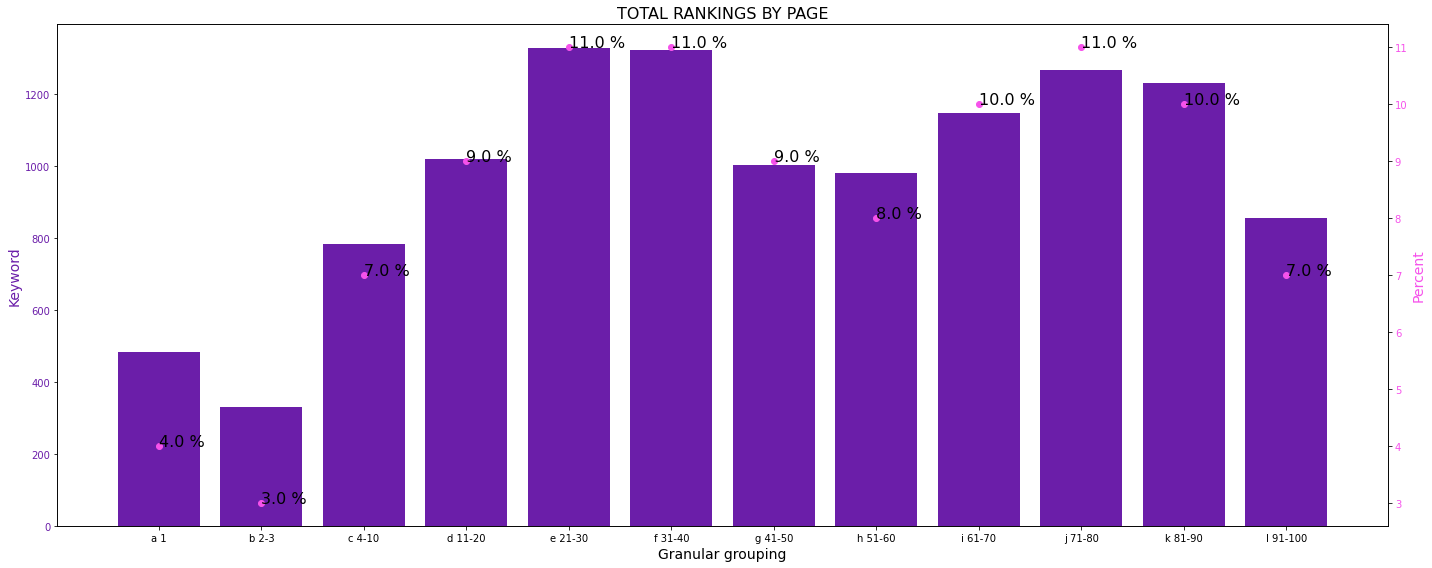

In [ ]:
#Plotting TOTAL RANKINGS BY PAGES
x = subtot_granular['Granular grouping']
y1 = subtot_granular['Keyword']
y2 = subtot_granular['Percent']
x_label, y1_label, y2_label = subtot_granular.columns
char_title = "TOTAL RANKINGS BY PAGE"
size = (20, 8)
vertical_plot_percentage(x, y1, y2, x_label, y1_label, y2_label, char_title, size)

###Plotting total rankings by Page Column

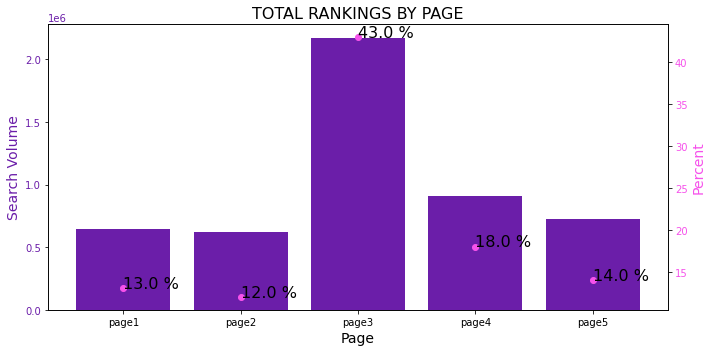

In [ ]:
#Plotting TOTAL RANKINGS BY PAGES
x = subtotals_pages['Page']
y1 = subtotals_pages['Search Volume']
y2 = subtotals_pages['Percent']
x_label, y1_label, y2_label = subtotals_pages.columns
char_title = "TOTAL RANKINGS BY PAGE"
size = (10, 5)
vertical_plot_percentage(x, y1, y2, x_label, y1_label, y2_label, char_title, size)

###Plotting total rankings by branded Keywords

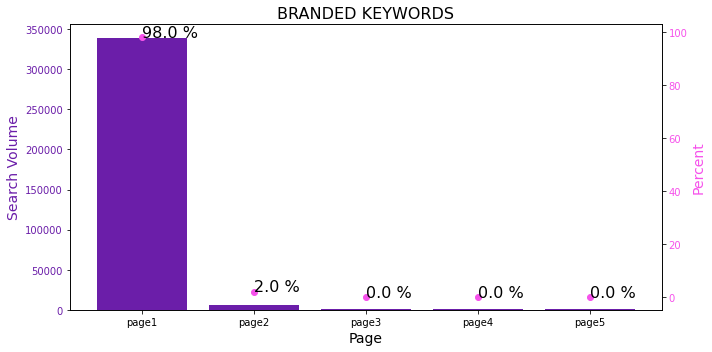

In [ ]:
#Plotting TOTAL RANKINGS BY PAGES
x = branded['Page']
y1 = branded['Search Volume']
y2 = branded['Percent']
x_label, y1_label, y2_label = branded.columns
char_title = "BRANDED KEYWORDS"
size = (10, 5)
vertical_plot_percentage(x, y1, y2, x_label, y1_label, y2_label, char_title, size)

###Plotting total rankings by non-branded keywords

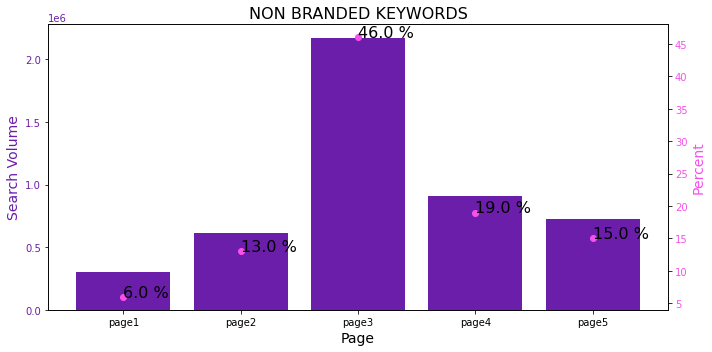

In [ ]:
#Plotting TOTAL RANKINGS BY NON-BRANDED 
x = no_branded['Page']
y1 = no_branded['Search Volume']
y2 = no_branded['Percent']
x_label, y1_label, y2_label = no_branded.columns
char_title = "NON BRANDED KEYWORDS"
size = (10, 5)
vertical_plot_percentage(x, y1, y2, x_label, y1_label, y2_label, char_title, size)

###Plotting branded vs non-branded keywords

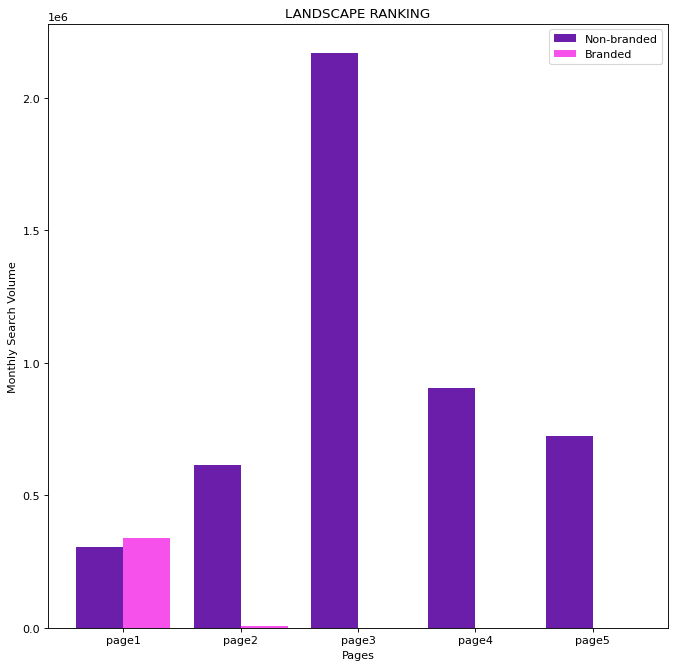

In [ ]:
x = no_branded['Page']
y1 = no_branded['Search Volume']
y2 = branded['Search Volume']
  
X_axis = np.arange(len(x))
plt.figure(figsize = (10, 10), dpi = 80)  
plt.bar(X_axis - 0.2, y1, 0.4, label = 'Non-branded', color = '#6b1ea9')
plt.bar(X_axis + 0.2, y2, 0.4, label = 'Branded', color = '#f652eb')

plt.xticks(X_axis, x)
plt.xlabel("Pages")
plt.ylabel("Monthly Search Volume")
plt.title("LANDSCAPE RANKING")
plt.legend()
plt.show()

###Plotting total rankings by website categories

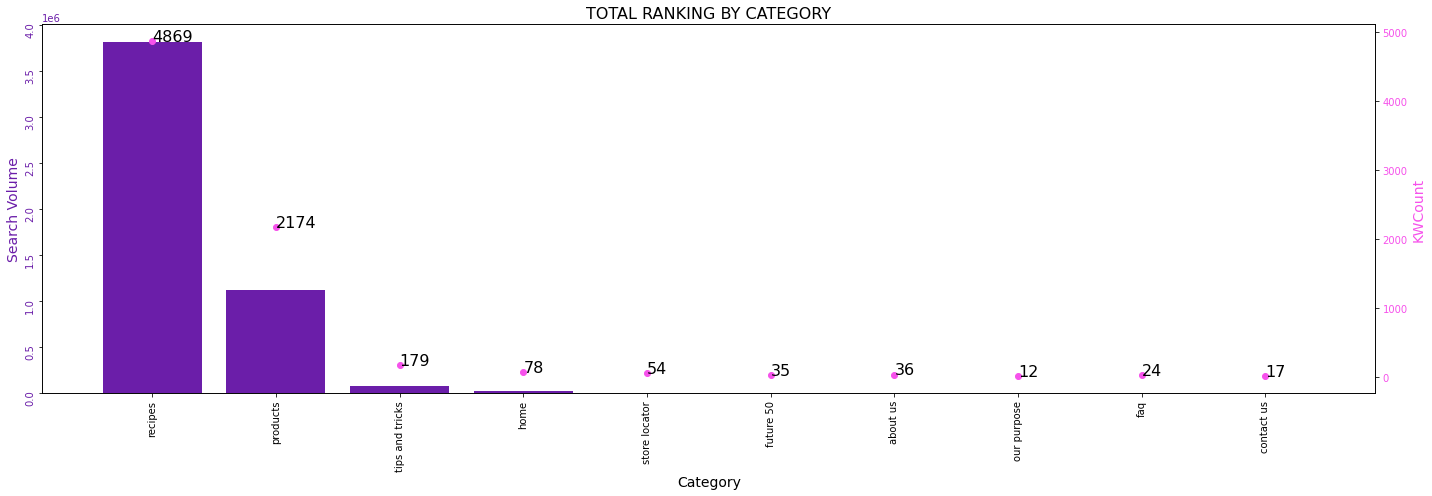

In [ ]:
#Plotting TOTAL RANKINGS BY PAGES
x = categories['Category']
y1 = categories['Search Volume']
y2 = categories['KWCount']
x_label, y1_label, y2_label = categories.columns
#print(categories.columns)
char_title = "TOTAL RANKING BY CATEGORY"
size = (20, 7)
vertical_plot(x, y1, y2, x_label, y1_label, y2_label, char_title, size)

###Plotting Striking distance URLs

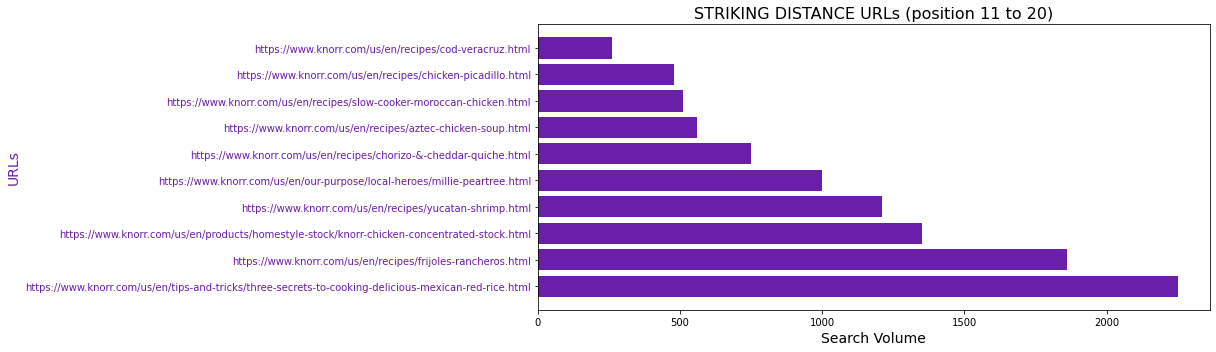

In [ ]:
#Ploting Branded URLs by range 10 to 20 positions bar char
fig, ax1 = plt.subplots(figsize = (17, 5))

color = '#6b1ea9'
ax1.set_xlabel('Search Volume', size = 14)
ax1.set_ylabel('URLs', color = color ,size = 14)
ax1.barh(table_position_b['URL'], table_position_b['Search Volume'], color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

plt.title("STRIKING DISTANCE URLs (position 11 to " + str(number) + ")", size = 16)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()